In [1]:
from gerrychain import Graph


In [23]:
from gerrychain import Graph
import os

filepath = '/Users/cherr/anaconda-gurobi/gurobi classes/'
filename = 'Iowa_county.json'

# Verify if the file is there at the given location.
file_path = os.path.join(filepath, filename)
if os.path.exists(file_path):
    # Proceed to read the file if it exists.
    Gr = Graph.from_json(file_path)
    # Use the graph to perform operations.
else:
    print(f"File '{filename}' not found in the specified directory.")


In [3]:
for node in Gr.nodes:
    Gr.nodes[node]['TOTPOP'] = Gr.nodes[node]['P0010001']

In [4]:
# Let us apply a population deviation of 1% (+/-0.5%).
deviation = 0.01

import math
k = 4          # of districts
total_population = sum( Gr.nodes[node]['TOTPOP'] for node in Gr.nodes )

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 793605 and U = 801580 and k = 4


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
model = gp.Model()

# create variables
a = model.addVars(Gr.nodes, k, vtype=GRB.BINARY) # When county i is allocated to district j, x[i,j] = 1.
b = model.addVars(Gr.edges, vtype=GRB.BINARY)    # When edge {u,v} is sliced, y[u,v] = 1.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-10


In [6]:
# The objective is to minimize the cut edges
model.setObjective( gp.quicksum( b[u,v] for u,v in Gr.edges ), GRB.MINIMIZE )

In [7]:
# add constraints such that each county i is allocated to 1 district
model.addConstrs( gp.quicksum(a[i,j] for j in range(k)) == 1 for i in Gr.nodes)

# add constraints such that Every district has a minimum population of L and a maximum population of U.
model.addConstrs( gp.quicksum( Gr.nodes[i]['TOTPOP'] * a[i,j] for i in Gr.nodes) >= L for j in range(k) )
model.addConstrs( gp.quicksum( Gr.nodes[i]['TOTPOP'] * a[i,j] for i in Gr.nodes) <= U for j in range(k) )

# add constraints such that edge {u,v} is cut if u is allocated to district j but v is not.
model.addConstrs( a[u,j] - a[v,j] <= b[u,v] for u,v in Gr.edges for j in range(k))

model.update()

In [10]:
# Incorporate root variables: if node i is the "root" of district j, then r[i,j] = 1.
root = model.addVars( Gr.nodes, k, vtype=GRB.BINARY )

#Add flow variables f[u,v] = flow delivered across arc uv. 

import networkx as nx
DG = nx.DiGraph(Gr)      # directed version of G

f = model.addVars( DG.edges )

In [12]:
# The big-M proposed by Hojny et al.
M = Gr.number_of_nodes() - k + 1

# District J ought to have a single root.
model.addConstrs( gp.quicksum( root[i,j] for i in Gr.nodes ) == 1 for j in range(k) )

# Node I cannot be the root of district J if it is not allocated to it.
model.addConstrs( root[i,j] <= a[i,j] for i in Gr.nodes for j in range(k) ) 

# use some flow if it's not a root.
# send out just a certain amount of flow if a root.
model.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in Gr.neighbors(i) ) 
             >= 1 - M * gp.quicksum( root[i,j] for j in range(k) ) for i in Gr.nodes )

# Send flow across edges that have been sliced.
model.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - b[i,j] ) for i,j in Gr.edges )

model.update()

In [13]:
# solve IP model
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1720 rows, 1854 columns and 7386 nonzeros
Model fingerprint: 0x6c15397c
Variable types: 444 continuous, 1410 integer (1410 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 4 rows and 396 columns
Presolve time: 0.03s
Presolved: 1716 rows, 1458 columns, 6990 nonzeros
Variable types: 444 continuous, 1014 integer (1014 binary)

Root relaxation: objective 0.000000e+00, 756 iterations, 0.04 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  412          -    0.00000 

 216570 59717   32.82717   44  200   35.00000   25.75418  26.4%   116  391s
 218654 60425   32.19822   35  335   35.00000   25.78155  26.3%   117  398s
 220004 60815   29.79531   34  330   35.00000   25.81173  26.3%   117  402s
 221285 61177   33.19718   35  385   35.00000   25.83373  26.2%   117  406s
 222574 61487     cutoff   34        35.00000   25.86053  26.1%   117  410s
 225116 62252     cutoff   42        35.00000   25.89621  26.0%   117  417s
 226436 62587   27.41200   26  428   35.00000   25.91977  25.9%   118  420s
 228653 63297   31.00404   31  435   35.00000   25.95694  25.8%   118  428s
 229769 63632   32.71093   32  368   35.00000   25.97438  25.8%   118  432s
 230998 64035   30.25046   29  405   35.00000   26.00245  25.7%   118  435s
 233617 64682   32.58850   32  438   35.00000   26.03979  25.6%   118  442s
 234878 65033   30.09363   32  373   35.00000   26.05319  25.6%   119  446s
 236966 65749   30.84169   28  356   35.00000   26.08967  25.5%   119  453s
 238417 6613

 423309 65492   30.94290   35  381   33.00000   28.38885  14.0%   126  955s
 426941 65312   28.74985   40  236   33.00000   28.42865  13.9%   126  960s
 430745 65076   29.83847   36  182   33.00000   28.47566  13.7%   126  965s
 433208 64914   30.07009   39  332   33.00000   28.50396  13.6%   126  970s
 436816 64669   31.87020   29  309   33.00000   28.54844  13.5%   126  976s
 439248 64496   30.84389   36  430   33.00000   28.57703  13.4%   126  980s
 443131 64289     cutoff   30        33.00000   28.61761  13.3%   126  985s
 446546 64014   31.22737   40  385   33.00000   28.65904  13.2%   126  990s
 449191 63853     cutoff   35        33.00000   28.68717  13.1%   126  995s
 452840 63604   30.56336   35  344   33.00000   28.73056  12.9%   126 1001s
 456627 63310     cutoff   33        33.00000   28.77386  12.8%   126 1006s
 459034 63129   30.78239   30  408   33.00000   28.80035  12.7%   126 1010s
 462365 62804   30.84717   34  250   33.00000   28.83862  12.6%   126 1015s
 466206 6237

In [15]:
print("The number of cut edges is",model.objval)

# get the districts and people living in them.
districts = [ [i for i in Gr.nodes if a[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ Gr.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(Gr.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]


# print the information of each district
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 33.0
District 0 has population 801285 and contains counties ['Wright', 'Montgomery', 'Sac', 'Audubon', 'Boone', 'Plymouth', 'Pottawattamie', 'Taylor', 'Page', 'Cherokee', 'Fremont', 'Emmet', 'Woodbury', 'Clay', 'Crawford', 'Osceola', 'Greene', 'Lyon', 'Adams', 'Monona', 'Humboldt', "O'Brien", 'Guthrie', 'Sioux', 'Winnebago', 'Ida', 'Cass', 'Carroll', 'Pocahontas', 'Kossuth', 'Harrison', 'Webster', 'Palo Alto', 'Calhoun', 'Hancock', 'Shelby', 'Dickinson', 'Buena Vista', 'Mills', 'Dallas']

District 1 has population 798919 and contains counties ['Story', 'Mitchell', 'Grundy', 'Winneshiek', 'Marshall', 'Delaware', 'Floyd', 'Jones', 'Hardin', 'Butler', 'Buchanan', 'Cerro Gordo', 'Tama', 'Hamilton', 'Franklin', 'Bremer', 'Allamakee', 'Howard', 'Clinton', 'Worth', 'Black Hawk', 'Fayette', 'Chickasaw', 'Dubuque', 'Benton', 'Jackson', 'Clayton']

District 2 has population 794693 and contains counties ['Union', 'Polk', 'Davis', 'Jasper', 'Wapello', 'Monroe', 'Lucas', 

In [16]:
# So let's repair some district roots and solve the MIP more quickly.:

root[8,1].LB = 1  # Fix Polk County as root of district 0
root[88,3].LB = 1 # Fix Linn County as root of district 1
root[25,2].LB = 1  # Fix Scott County as root of district 2

model.reset()      # Make Gurobi begin solving problems "from scratch"
model.optimize()

Discarded solution information
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1720 rows, 1854 columns and 7386 nonzeros
Model fingerprint: 0xacb86fc3
Variable types: 444 continuous, 1410 integer (1410 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 370 rows and 723 columns
Presolve time: 0.01s
Presolved: 1350 rows, 1131 columns, 5574 nonzeros
Variable types: 444 continuous, 687 integer (687 binary)

Root relaxation: objective 1.181523e+01, 1116 iterations, 0.04 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.81523 

 224425 16975     cutoff   28        33.00000   29.35594  11.0%   151  411s
 226889 16664   31.55843   28  267   33.00000   29.42364  10.8%   151  415s
 231054 16258     cutoff   28        33.00000   29.53792  10.5%   151  422s
 232578 16095     cutoff   28        33.00000   29.57090  10.4%   151  435s
 233803 15937   31.37225   26  396   33.00000   29.60557  10.3%   151  441s
 236349 15606   31.75603   35  257   33.00000   29.66140  10.1%   151  445s
 239663 15177     cutoff   37        33.00000   29.74884  9.85%   151  450s
 243615 14452   31.64593   28  374   33.00000   29.85617  9.53%   151  455s
 247309 13684   30.44064   28  356   33.00000   29.96988  9.18%   151  461s
 248744 13426   31.41952   28  318   33.00000   30.00953  9.06%   151  465s
 251298 12846     cutoff   30        33.00000   30.08530  8.83%   150  471s
 255455 11933   31.57487   26  429   33.00000   30.19166  8.51%   150  475s
 260789 10516     cutoff   36        33.00000   30.37218  7.96%   150  480s
 264934  924

In [18]:
print("The number of cut edges is",model.objval)

# retrieve the districts and their populations
districts = [ [i for i in Gr.nodes if a[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ Gr.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(Gr.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print the information of each district
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 33.0
District 0 has population 799340 and contains counties ['Wright', 'Montgomery', 'Union', 'Sac', 'Audubon', 'Hardin', 'Plymouth', 'Pottawattamie', 'Taylor', 'Page', 'Cherokee', 'Fremont', 'Emmet', 'Woodbury', 'Clay', 'Crawford', 'Osceola', 'Cerro Gordo', 'Greene', 'Lyon', 'Adams', 'Monona', 'Humboldt', 'Hamilton', 'Franklin', "O'Brien", 'Guthrie', 'Sioux', 'Winnebago', 'Ida', 'Cass', 'Decatur', 'Carroll', 'Pocahontas', 'Kossuth', 'Harrison', 'Webster', 'Palo Alto', 'Ringgold', 'Calhoun', 'Worth', 'Adair', 'Hancock', 'Shelby', 'Dickinson', 'Buena Vista', 'Mills']

District 1 has population 795249 and contains counties ['Story', 'Polk', 'Marshall', 'Boone', 'Jasper', 'Dallas']

District 2 has population 797710 and contains counties ['Keokuk', 'Davis', 'Des Moines', 'Scott', 'Lee', 'Iowa', 'Wapello', 'Henry', 'Louisa', 'Monroe', 'Muscatine', 'Lucas', 'Washington', 'Cedar', 'Jefferson', 'Madison', 'Clarke', 'Warren', 'Poweshiek', 'Wayne', 'Marion', 'Mahaska',

In [19]:
# Let's draw the new congressional districts on the map
import geopandas as gpd

In [21]:
# Read Iowa county shapefile from "Iowa_county.shp"
filepath = 'C:/Users/cherr/anaconda-gurobi/gurobi classes/'
filename = 'Iowa_county.shp'

# Read Geo-pandas dataframe from file
df = gpd.read_file( filepath + filename )

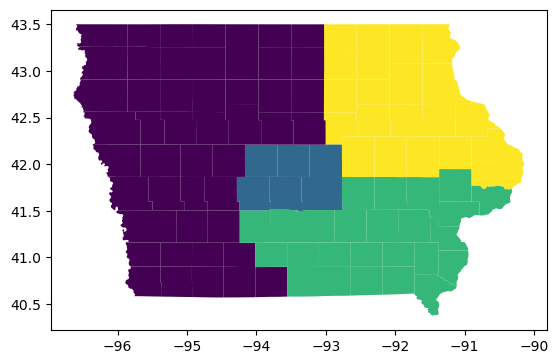

In [22]:
# To Which district each county is assigned to?
assignment = [ -1 for i in Gr.nodes ]

labeling = { i : j for i in Gr.nodes for j in range(k) if a[i,j].x > 0.5 }

# Now, add the assignments to a dataframe column and map it.
node_with_this_geoid = { Gr.nodes[i]['GEOID20'] : i for i in Gr.nodes }

# Select a point u inside the dataframe.
for u in range(Gr.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # Which G node contains this geoid?
    i = node_with_this_geoid[geoid]
    
   # In the dataframe's location u should be provided.
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a dataframe column and map it.
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()